In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Preparation**

In [ ]:
import pickle

# Load the dataset using the pickle library
# The dataset is expected to be a serialized Python object
dataset_path = '/content/drive/My Drive/CS 547/DeepDiveProject/working_dataset.pickle'
with open(dataset_path, 'rb') as file:
    data = pickle.load(file)


In [ ]:
# dataset structure
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8103694 entries, 0 to 8185548
Data columns (total 25 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Case Number           object        
 2   Date                  datetime64[ns]
 3   Block                 object        
 4   IUCR                  object        
 5   Primary Type          object        
 6   Description           object        
 7   Location Description  object        
 8   Arrest                bool          
 9   Domestic              bool          
 10  Beat                  int64         
 11  District              float64       
 12  Ward                  float64       
 13  Community Area        float64       
 14  FBI Code              object        
 15  X Coordinate          float64       
 16  Y Coordinate          float64       
 17  Year                  int64         
 18  Updated On            datetime64[ns]
 19  Latit

**Some Exploration of the data**


1. Primary Type of Crime Distribution: Visualizing crime types helps identify the most common offenses, guiding resource allocation.

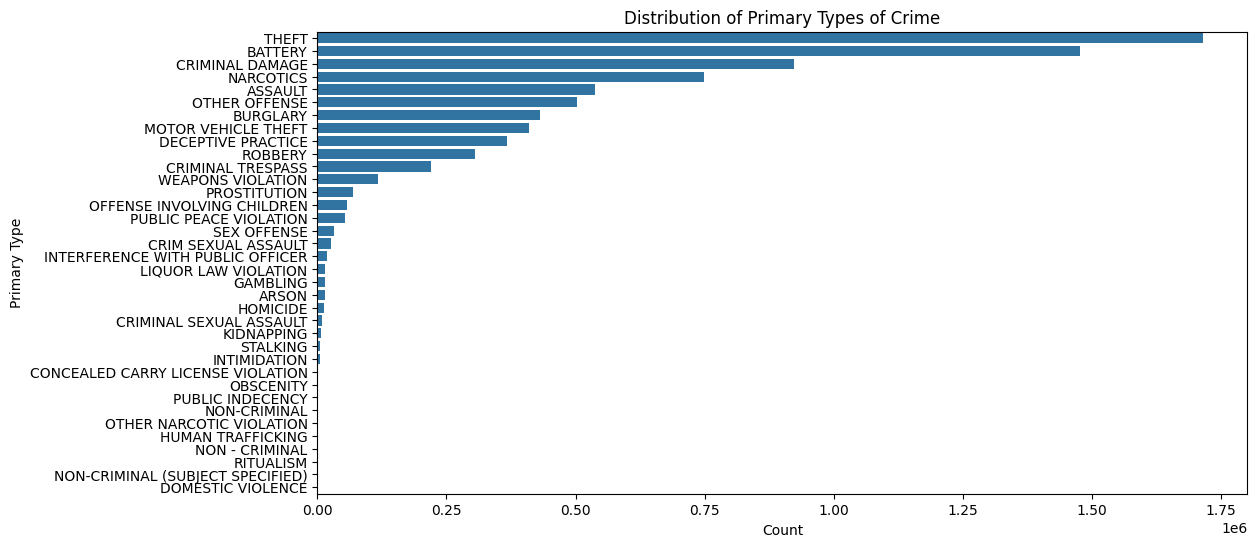

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

primary_type_data = data['Primary Type'].dropna()

plt.figure(figsize=(12, 6))
sns.countplot(y=primary_type_data, order=primary_type_data.value_counts().index)
plt.title("Distribution of Primary Types of Crime")
plt.xlabel("Count")
plt.ylabel("Primary Type")
plt.show()

2. Crime by Hour and Day (Heatmap): Shows peak crime times, aiding in targeted preventive measures by time and day.

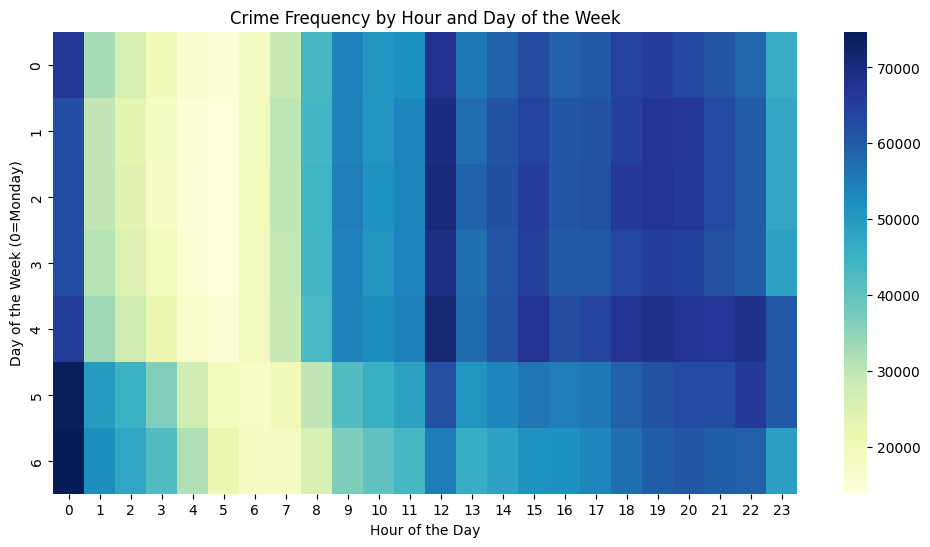

In [ ]:
import pandas as pd

data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])

data['Hour'] = data['Date'].dt.hour
data['Day of Week'] = data['Date'].dt.dayofweek

heatmap_data = data.pivot_table(index='Day of Week', columns='Hour', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False)
plt.title("Crime Frequency by Hour and Day of the Week")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week (0=Monday)")
plt.show()

3. Crime Trends Over Time: Tracks crime patterns over time, revealing trends for policy and response adjustments.

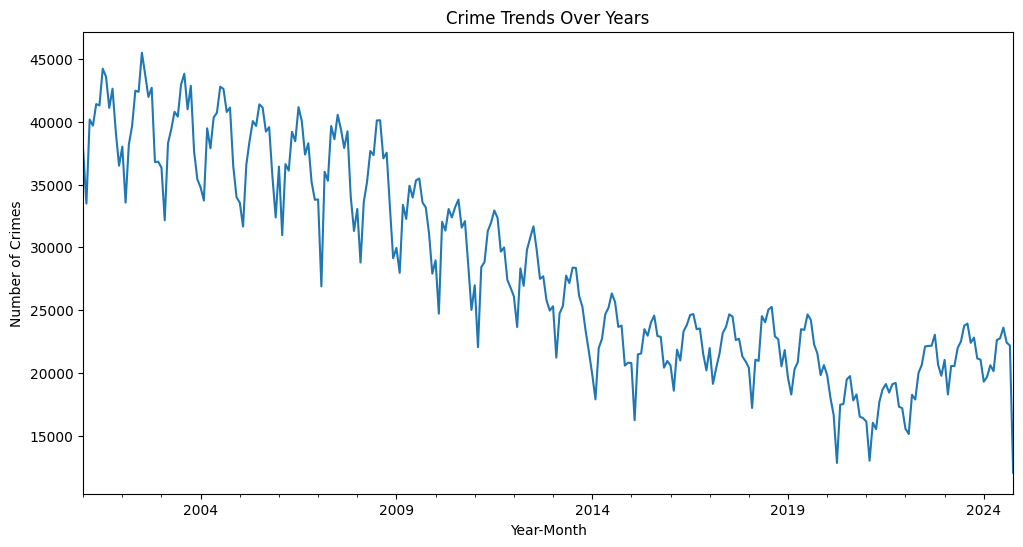

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])

data['Year-Month'] = data['Date'].dt.to_period('M')

trend_data = data.groupby('Year-Month').size()

plt.figure(figsize=(12, 6))
trend_data.plot()
plt.title("Crime Trends Over Years")
plt.xlabel("Year-Month")
plt.ylabel("Number of Crimes")
plt.show()

4. Geographic Crime Distribution: Maps crime locations, highlighting high-risk areas for focused interventions. Outliers were removed to highlight the main cluster for clearer insights into high-risk areas

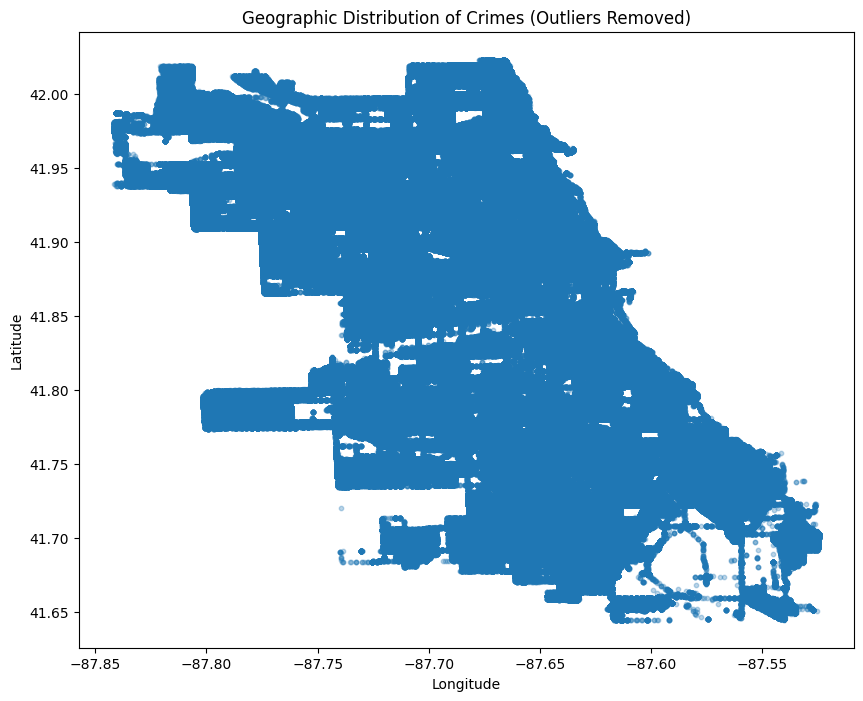

In [ ]:
import numpy as np

geo_data = data.dropna(subset=['Latitude', 'Longitude'])

Q1_lat, Q3_lat = np.percentile(geo_data['Latitude'], [25, 75])
IQR_lat = Q3_lat - Q1_lat

Q1_lon, Q3_lon = np.percentile(geo_data['Longitude'], [25, 75])
IQR_lon = Q3_lon - Q1_lon

lat_lower_bound = Q1_lat - 1.5 * IQR_lat
lat_upper_bound = Q3_lat + 1.5 * IQR_lat
lon_lower_bound = Q1_lon - 1.5 * IQR_lon
lon_upper_bound = Q3_lon + 1.5 * IQR_lon

geo_data_filtered = geo_data[
    (geo_data['Latitude'] >= lat_lower_bound) & (geo_data['Latitude'] <= lat_upper_bound) &
    (geo_data['Longitude'] >= lon_lower_bound) & (geo_data['Longitude'] <= lon_upper_bound)
]

plt.figure(figsize=(10, 8))
plt.scatter(geo_data_filtered['Longitude'], geo_data_filtered['Latitude'], alpha=0.3, s=10)
plt.title("Geographic Distribution of Crimes (Outliers Removed)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

5. Statistics of arrests: Statistics for arrests, as well as relationship with crime type and region. We think that rate of arrest has impact of type of crime on the region.

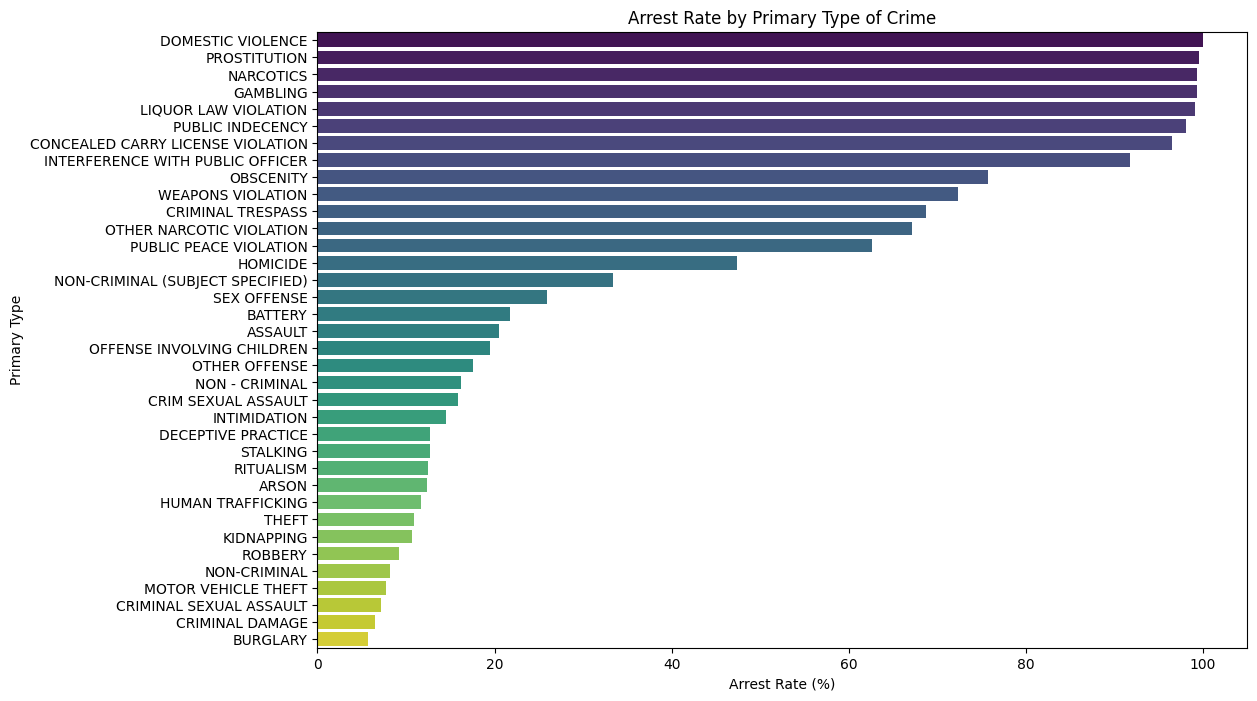

In [ ]:
total_incidents = data['Primary Type'].value_counts()
arrests = data[data['Arrest'] == True]['Primary Type'].value_counts()
arrests = arrests.reindex(total_incidents.index, fill_value=0)
arrest_rate = (arrests / total_incidents) * 100
crime_arrest_stats = pd.DataFrame({
    'Total Incidents': total_incidents,
    'Number of Arrests': arrests,
    'Arrest Rate (%)': arrest_rate
})

crime_arrest_stats_sorted = crime_arrest_stats.sort_values(by='Arrest Rate (%)', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(data=crime_arrest_stats_sorted, x='Arrest Rate (%)', y=crime_arrest_stats_sorted.index, hue=crime_arrest_stats_sorted.index, dodge=False, palette="viridis", legend=False)
plt.title('Arrest Rate by Primary Type of Crime')
plt.xlabel('Arrest Rate (%)')
plt.ylabel('Primary Type')
plt.show()



In [ ]:
total_incidents_by_district = data['District'].value_counts()
arrests_by_district = data[data['Arrest'] == True]['District'].value_counts()
arrests_by_district = arrests_by_district.reindex(total_incidents_by_district.index, fill_value=0)
arrest_rate_by_district = (arrests_by_district / total_incidents_by_district) * 100
district_stats = pd.DataFrame({
    'Total Crimes': total_incidents_by_district,
    'Number of Arrests': arrests_by_district,
    'Arrest Rate (%)': arrest_rate_by_district
})

district_stats = district_stats.sort_index()
print(district_stats)


          Total Crimes  Number of Arrests  Arrest Rate (%)
District                                                  
1.0             333811              88292        26.449698
2.0             385019              96819        25.146551
3.0             410788             101663        24.748289
4.0             459265              99826        21.736035
5.0             357410              88333        24.714753
6.0             473842             118808        25.073337
7.0             462160             127116        27.504760
8.0             543978             119776        22.018538
9.0             394101             106502        27.024037
10.0            348501             107392        30.815407
11.0            516426             213210        41.285683
12.0            406114              89049        21.927094
14.0            312930              62272        19.899658
15.0            343252             131365        38.270717
16.0            272306              49838        18.3022

District-level analysis shows that high-crime districts with low arrest rates may indicate challenges in enforcement, potentially affecting model accuracy for predicting crime types in these areas.

**Discriptive statistics**



On crime hours of the day

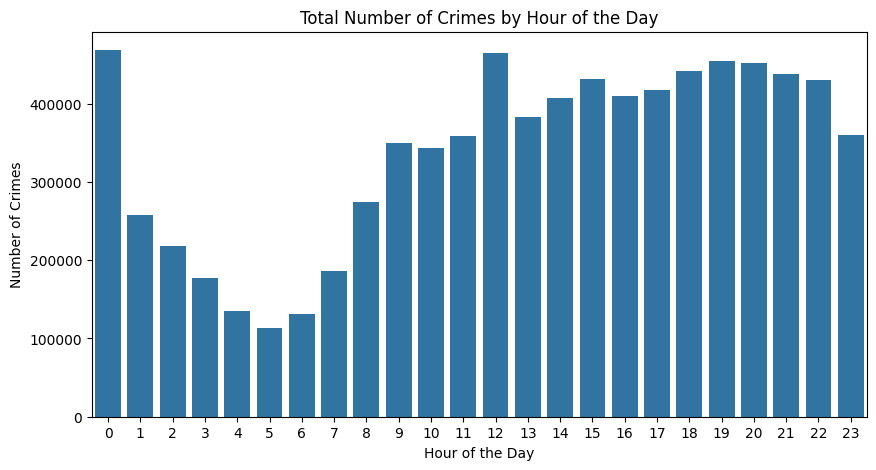

In [ ]:
hourly_crime_counts = data['Hour'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=hourly_crime_counts.index, y=hourly_crime_counts.values)
plt.title("Total Number of Crimes by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Crimes")
plt.show()

In [ ]:
hourly_mean = hourly_crime_counts.mean()
hourly_max = hourly_crime_counts.max()
hourly_min = hourly_crime_counts.min()

print(f"Average crimes per hour: {hourly_mean:.2f}")
print(f"Peak crime hour count: {hourly_max}")
print(f"Lowest crime hour count: {hourly_min}")


Average crimes per hour: 337653.92
Peak crime hour count: 468510
Lowest crime hour count: 113145


In [ ]:
peak_day_hour = heatmap_data.stack().idxmax()
peak_crime_count = heatmap_data.stack().max()

print(f"Peak crime time: Day {peak_day_hour[0]} at Hour {peak_day_hour[1]}")
print(f"Number of crimes at peak time: {peak_crime_count}")

average_crimes_per_hour = heatmap_data.mean(axis=0)
print("Average crimes per hour across all days:\n", round(average_crimes_per_hour, 2))


Peak crime time: Day 6 at Hour 0
Number of crimes at peak time: 74710
Average crimes per hour across all days:
 Hour
0     66930.00
1     36861.00
2     31144.43
3     25281.00
4     19301.29
5     16163.57
6     18720.43
7     26566.57
8     39185.71
9     49933.29
10    49075.00
11    51270.29
12    66405.29
13    54781.86
14    58152.00
15    61632.00
16    58605.43
17    59561.71
18    63153.71
19    64909.57
20    64579.29
21    62576.00
22    61514.57
23    51366.57
dtype: float64


The following graph reveals label bias by showing how crime types vary across Wards, which may reflect unequal law enforcement or reporting practices rather than true crime distribution.

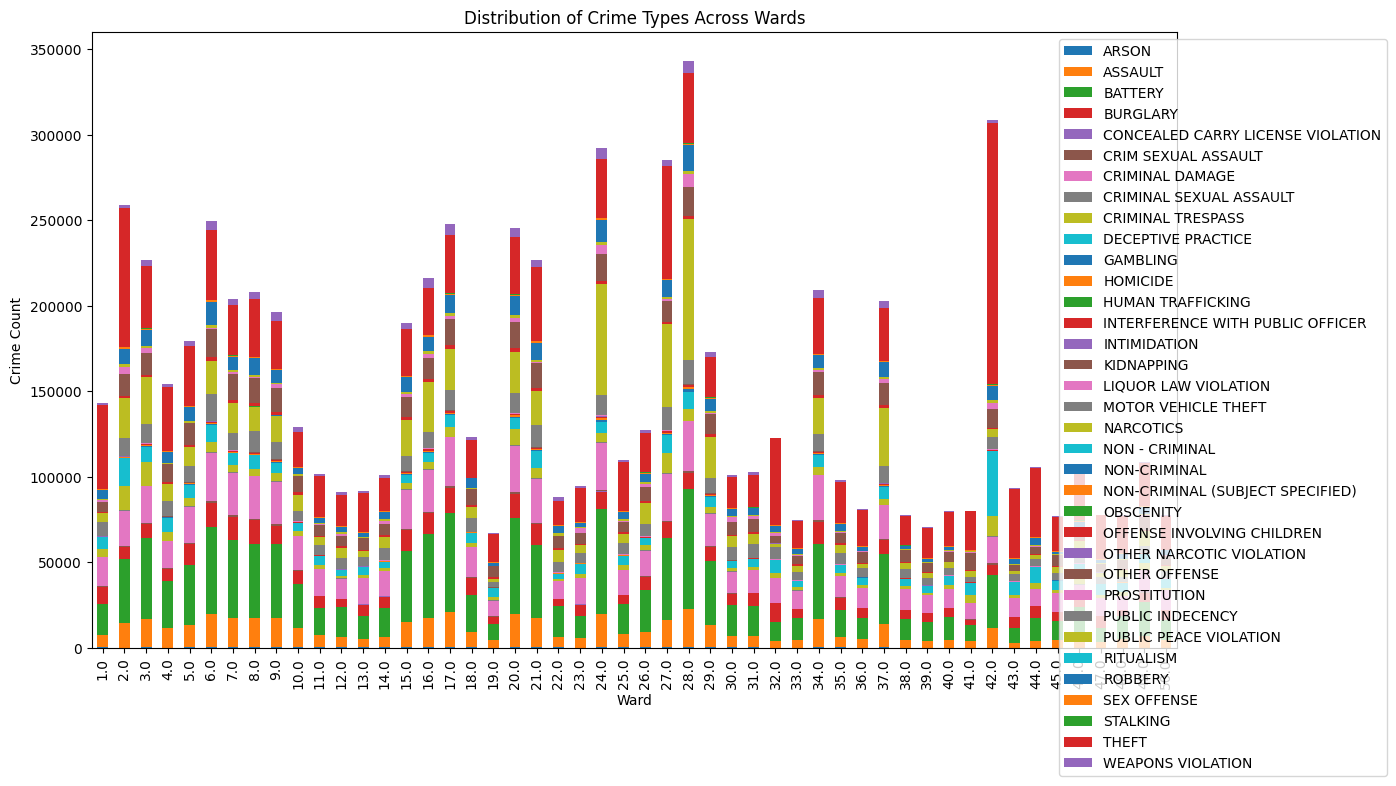

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data_filtered = data.dropna(subset=['Ward', 'Primary Type'])

crime_by_ward = data_filtered.pivot_table(index='Ward', columns='Primary Type', aggfunc='size', fill_value=0)

crime_by_ward.plot(kind='bar', stacked=True, figsize=(14, 8), legend=False)
plt.title("Distribution of Crime Types Across Wards")
plt.xlabel("Ward")
plt.ylabel("Crime Count")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

**Missing Data Problem**

In [ ]:
missing_rows_percentage = (data.isnull().any(axis=1).mean()) * 100

print(f"Percentage of rows with missing data: {missing_rows_percentage:.2f}%")

Percentage of rows with missing data: 8.62%


The percentage missing data is relatively small, we will drop rows containing missing values in our later stages (as done in visualization steps).